In [1]:
import numpy as np
import requests
import pandas as pd
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

In [2]:
SEED = 42
N_PER_CLASS = 200
FETCH_TARGET_PER_CLASS = 600   
TEST_SIZE = 0.15

OUT_DIR = "outputs"

METHOD_TERMS = '("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")'

CATEGORIES = [
    ("a", "Alzheimer", f'(Alzheimer* OR "Alzheimer disease" OR AD) AND {METHOD_TERMS}'),
    ("b", "Parkinson", f'(Parkinson* OR PD) AND {METHOD_TERMS}'),
    ("c", "Vascular dementia", f'("vascular dementia" OR "vascular cognitive impairment" OR VCI) AND {METHOD_TERMS}'),
    ("d", "MCI", f'("mild cognitive impairment" OR MCI) AND {METHOD_TERMS}'),
    ("e", "Lewy body dementia", f'("Lewy body dementia" OR DLB OR "dementia with lewy bodies") AND {METHOD_TERMS}'),
]

BASE_URL = "https://www.ebi.ac.uk/europepmc/webservices/rest/search"

In [3]:
for label, cat, q in CATEGORIES:
    print(label, cat)
    print("  ", q)
    print()

a Alzheimer
   (Alzheimer* OR "Alzheimer disease" OR AD) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

b Parkinson
   (Parkinson* OR PD) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

c Vascular dementia
   ("vascular dementia" OR "vascular cognitive impairment" OR VCI) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

d MCI
   ("mild cognitive impairment" OR MCI) AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")

e Lewy body dementia
   ("Lewy body dementia" OR DLB OR "dementia with lewy bodies") AND ("machine learning" OR "deep learning" OR "neural network" OR NLP OR "natural language processing" OR "text mining")



In [4]:
def epmc_search_once(query, page_size=5):
    params = {
        "query": query,
        "format": "json",
        "resultType": "core",
        "pageSize": page_size
    }
    r = requests.get(BASE_URL, params=params, timeout=30)
    r.raise_for_status()
    return r.json()


test_json = epmc_search_once(CATEGORIES[0][2], page_size=5)


results = test_json.get("resultList", {}).get("result", [])
len(results), results[0].get("title") if results else None

(5, 'Machine Learning in Primary Health Care: The Research Landscape.')

In [5]:
import time
import requests

def epmc_search_all(query, max_records=500, page_size=100, result_type="core", sleep=0.15):
    records = []
    cursor = "*"
    while len(records) < max_records:
        params = {
            "query": query,
            "format": "json",
            "resultType": result_type,
            "pageSize": page_size,
            "cursorMark": cursor
        }
        r = requests.get(BASE_URL, params=params, timeout=30)
        r.raise_for_status()
        data = r.json()

        batch = data.get("resultList", {}).get("result", [])
        if not batch:
            break

        records.extend(batch)

        next_cursor = data.get("nextCursorMark")
        if not next_cursor or next_cursor == cursor:
            break
        cursor = next_cursor
        time.sleep(sleep)

    return records[:max_records]

In [6]:
FETCH_TARGET_PER_CLASS = 800  
all_rows = []

for label, cat, q in CATEGORIES:
    print(f"\nFetching {cat} ...")
    recs = epmc_search_all(q, max_records=FETCH_TARGET_PER_CLASS, page_size=100, result_type="core")
    print("Fetched:", len(recs))

    for x in recs:
        all_rows.append({
            "doc_id": f'{x.get("id","")}_{x.get("source","")}',
            "label": label,
            "category": cat,
            "title": x.get("title"),
            "abstract": x.get("abstractText"),
            "year": x.get("pubYear"),
            "doi": x.get("doi"),
            "journalTitle": x.get("journalTitle"),
            "pubType": x.get("pubType"),
            "source": x.get("source")
        })

raw_df = pd.DataFrame(all_rows)
print("\nRaw size:", raw_df.shape)
raw_df["label"].value_counts()


Fetching Alzheimer ...
Fetched: 800

Fetching Parkinson ...
Fetched: 800

Fetching Vascular dementia ...
Fetched: 800

Fetching MCI ...
Fetched: 800

Fetching Lewy body dementia ...
Fetched: 800

Raw size: (4000, 10)


label
a    800
b    800
c    800
d    800
e    800
Name: count, dtype: int64

In [7]:
df = raw_df.dropna(subset=["abstract"]).copy()


df["dedup_key"] = df["doi"].fillna("")
mask = df["dedup_key"].eq("")
df.loc[mask, "dedup_key"] = (
    df.loc[mask, "title"].fillna("").str.lower().str.strip()
    + "_"
    + df.loc[mask, "year"].fillna("").astype(str)
)

df = df.drop_duplicates(subset=["dedup_key"]).copy()

print("After filter+dedup:", df.shape)
df["label"].value_counts()

After filter+dedup: (2966, 11)


label
a    731
c    683
b    606
e    533
d    413
Name: count, dtype: int64

In [8]:
SEED = 42
N_PER_CLASS = 200

samples = []
for label, cat, _ in CATEGORIES:
    sub = df[df["label"] == label].copy()
    print(cat, "available:", len(sub))
    if len(sub) < N_PER_CLASS:
        raise ValueError(f"{cat} only has {len(sub)} records; increase FETCH_TARGET_PER_CLASS or relax query.")
    samples.append(sub.sample(n=N_PER_CLASS, random_state=SEED))

df200 = pd.concat(samples, ignore_index=True)
print("df200 shape:", df200.shape)
df200["label"].value_counts()

Alzheimer available: 731
Parkinson available: 606
Vascular dementia available: 683
MCI available: 413
Lewy body dementia available: 533
df200 shape: (1000, 11)


label
a    200
b    200
c    200
d    200
e    200
Name: count, dtype: int64

In [9]:
import os
import re
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from sklearn.model_selection import train_test_split

OUT_DIR = "outputs"
os.makedirs(OUT_DIR, exist_ok=True)

def basic_clean(text: str) -> str:
    if text is None or (isinstance(text, float) and pd.isna(text)):
        return ""
    text = str(text).replace("\n", " ").replace("\r", " ")
    text = re.sub(r"\s+", " ", text).strip()
    text = re.sub(r"[^A-Za-z0-9\s\.\,\;\:\-\(\)\/%]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return re.findall(r"[A-Za-z0-9]+(?:'[A-Za-z0-9]+)?", text)

def remove_stopwords(tokens):
    return [t for t in tokens if t.lower() not in ENGLISH_STOP_WORDS]

def make_record(title, abstract, n_words=150, remove_sw=True, use_title=True):
    title = basic_clean(title)
    abstract = basic_clean(abstract)
    text = f"{title} {abstract}".strip() if use_title else abstract
    tokens = tokenize(text)
    if remove_sw:
        tokens = remove_stopwords(tokens)
    tokens = tokens[:n_words]
    return " ".join(tokens)

def build_and_split(df_in, n_words, use_title, out_name, seed=42, test_size=0.15):
    out = df_in.copy()
    out["text"] = out.apply(lambda r: make_record(r["title"], r["abstract"], n_words=n_words, use_title=use_title), axis=1)
    out = out[out["text"].str.len() > 0].copy()

    train_df, test_df = train_test_split(
        out, test_size=test_size, random_state=seed, stratify=out["label"]
    )
    train_df["split"] = "train"
    test_df["split"] = "test"
    final = pd.concat([train_df, test_df], ignore_index=True)

    keep = ["doc_id","label","category","year","text","split","source","journalTitle","doi","pubType"]
    keep = [c for c in keep if c in final.columns]
    path = os.path.join(OUT_DIR, out_name)
    final[keep].to_csv(path, index=False, encoding="utf-8")
    print("Saved:", path, "| rows:", len(final))
    return final

In [10]:
data_title_abs_150 = build_and_split(df200, n_words=150, use_title=True,  out_name="data_title_abstract_150w.csv", seed=SEED, test_size=0.15)
data_abs_only_150  = build_and_split(df200, n_words=150, use_title=False, out_name="data_abstract_only_150w.csv", seed=SEED, test_size=0.15)


data_title_abs_20  = build_and_split(df200, n_words=20,  use_title=True,  out_name="data_title_abstract_20w.csv", seed=SEED, test_size=0.15)

Saved: outputs\data_title_abstract_150w.csv | rows: 1000
Saved: outputs\data_abstract_only_150w.csv | rows: 1000
Saved: outputs\data_title_abstract_20w.csv | rows: 1000


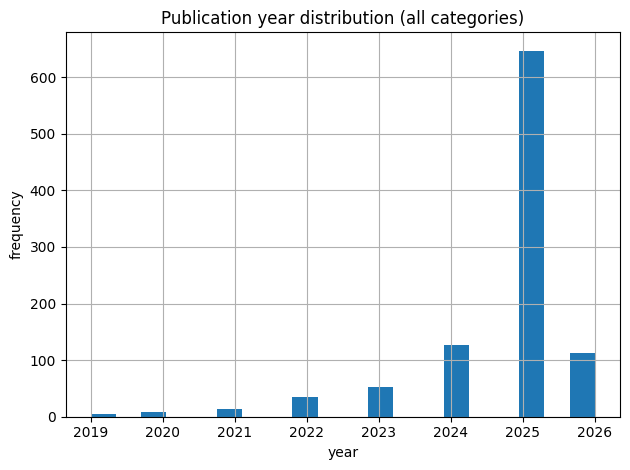

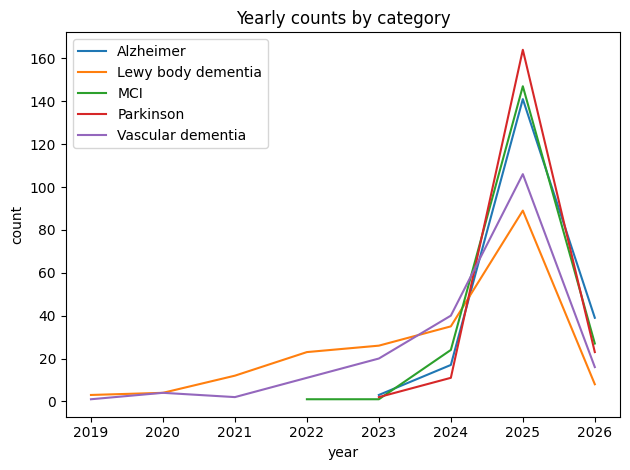

In [11]:
#Graphs

import pandas as pd
import matplotlib.pyplot as plt
import os

p_main = "outputs/data_title_abstract_150w.csv"
df_main = pd.read_csv(p_main)

df_main["year_num"] = pd.to_numeric(df_main["year"], errors="coerce")
years = df_main["year_num"].dropna()

years.hist(bins=20)
plt.title("Publication year distribution (all categories)")
plt.xlabel("year")
plt.ylabel("frequency")
plt.tight_layout()
plt.show()


trend = (
    df_main.dropna(subset=["year_num"])
          .groupby(["category", "year_num"])
          .size()
          .reset_index(name="count")
)

for cat in trend["category"].unique():
    sub = trend[trend["category"] == cat].sort_values("year_num")
    plt.plot(sub["year_num"], sub["count"], label=cat)

plt.title("Yearly counts by category")
plt.xlabel("year")
plt.ylabel("count")
plt.legend()
plt.tight_layout()
plt.show()

## Part 2

In [12]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

In [13]:
df = pd.read_csv("outputs/data_title_abstract_150w.csv")


train_df = df[df['split'] == 'train'].copy()
X_train_text = train_df['text'].fillna("") # Handle potential null values
y_train = train_df['category']             # labels (a, b, c, d, e)

# Encode labels
le = LabelEncoder()
y_train_enc = le.fit_transform(y_train)

# Feature Engineering: TF-IDF & N-gram
tfidf = TfidfVectorizer(
    stop_words='english',      # Remove English stop words such as "the, is, at..."
    ngram_range=(1, 2),        # Unigrams + Bigrams
    max_features=5000,         # Limit to top 5000 features
    sublinear_tf=True          
)

print("\nTF-IDF transformation in progress...")
X_train_vec = tfidf.fit_transform(X_train_text)

print(f"transformation complete! Shape of the generated feature matrix is {X_train_vec.shape}") #


TF-IDF transformation in progress...
transformation complete! Shape of the generated feature matrix is (850, 5000)


In [14]:
# Train a simple classifier (e.g., Multinomial Naive Bayes) to check if the features are reasonable

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, cohen_kappa_score, confusion_matrix
from scipy.optimize import linear_sum_assignment
from sklearn.preprocessing import LabelEncoder
import os

# Load the dataset
df = pd.read_csv(os.path.join(OUT_DIR, "data_title_abstract_150w.csv"))

# We do the clustering experiment on the training set
train_df = df[df['split'] == 'train'].copy()
texts = train_df['text'].values
true_labels = train_df['label'].values # 'a', 'b', 'c', 'd', 'e'

# Transform true labels to numeric for evaluation
le = LabelEncoder()
y_true = le.fit_transform(true_labels)
n_clusters = len(np.unique(y_true))

print(f"Total training records: {len(texts)}")
print(f"Number of target clusters: {n_clusters}")

Total training records: 850
Number of target clusters: 5


In [15]:
def get_cluster_mapping(y_true, y_pred):
    #Mapping predicted cluster labels to true labels
    D = max(y_pred.max(), y_true.max()) + 1
    w = np.zeros((D, D), dtype=np.int64)
    for i in range(y_pred.size):
        w[y_pred[i], y_true[i]] += 1
    row_ind, col_ind = linear_sum_assignment(w.max() - w)
    return row_ind, col_ind, w

def evaluate_clustering(X, y_true, model_name):
    # Run K-Means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    y_pred = kmeans.fit_predict(X)
    
    # Calculate silhouette score
    sil = silhouette_score(X, y_pred)
    
    # Map predicted cluster labels to true labels and calculate Kappa
    row_ind, col_ind, w = get_cluster_mapping(y_true, y_pred)
    map_dict = dict(zip(row_ind, col_ind))
    y_pred_aligned = np.array([map_dict[v] for v in y_pred])
    kappa = cohen_kappa_score(y_true, y_pred_aligned)
    
    # Calculate sparsity
    sparsity = 1.0 - (np.count_nonzero(X.toarray() if hasattr(X, "toarray") else X) / float(X.size))
    
    return {
        "Feature": model_name,
        "Dimension": X.shape[1],
        "Sparsity": f"{sparsity:.2%}",
        "Silhouette": round(sil, 4),
        "Kappa": round(kappa, 4)
    }, y_pred_aligned

results = []
feature_summaries = []

## Perform Feature Extraction and Experimentation

In [ ]:
# 1. BOW (Bag of Words)
print("Extracting BOW features...")
cv = CountVectorizer(max_features=2000, stop_words='english')
X_bow = cv.fit_transform(texts)
res_bow, _ = evaluate_clustering(X_bow, y_true, "BOW")
results.append(res_bow)

# 2. TF-IDF
print("Extracting TF-IDF features...")
tfidf = TfidfVectorizer(max_features=2000, stop_words='english', sublinear_tf=True)
X_tfidf = tfidf.fit_transform(texts)
res_tfidf, _ = evaluate_clustering(X_tfidf, y_true, "TF-IDF")
results.append(res_tfidf)

# 3. LDA (Topic Vectors)
print("Extracting LDA Topic Vectors...")
lda = LatentDirichletAllocation(n_components=20, random_state=42)
X_lda = lda.fit_transform(X_bow)

res_lda, _ = evaluate_clustering(X_lda, y_true, "LDA")
results.append(res_lda)

# 4. K-Means Cluster Assignments as Features
kmeans_feature_compare = pd.DataFrame(results)

print("\n--- Feature Experiment Results ---")
print(kmeans_feature_compare)

Extracting BOW features...
Extracting TF-IDF features...
Extracting LDA Topic Vectors...

--- Feature Experiment Results ---
  Feature  Dimension Sparsity  Silhouette   Kappa
0     BOW       2000    0.00%      0.0247  0.1735
1  TF-IDF       2000    0.00%      0.0119  0.2912
2     LDA         20    0.00%      0.2301  0.2794


In [18]:
def get_top_terms(vectorizer, n=10):
    feature_names = vectorizer.get_feature_names_out()
    # Calculate the sum of TF-IDF scores for each term across all documents
    sums = X_tfidf.sum(axis=0).A1
    top_indices = sums.argsort()[::-1][:n]
    return [feature_names[i] for i in top_indices]

# Generate feature summary table
feature_info = [
    {"Feature": "BOW", "Top Terms": ", ".join(cv.get_feature_names_out()[:10])},
    {"Feature": "TF-IDF", "Top Terms": ", ".join(tfidf.get_feature_names_out()[:10])}
]
features_summary_df = pd.DataFrame(feature_info)
print(features_summary_df)

  Feature                                   Top Terms
0     BOW  000, 001, 05, 10, 100, 11, 12, 123, 13, 14
1  TF-IDF  000, 001, 05, 10, 100, 11, 12, 123, 13, 14


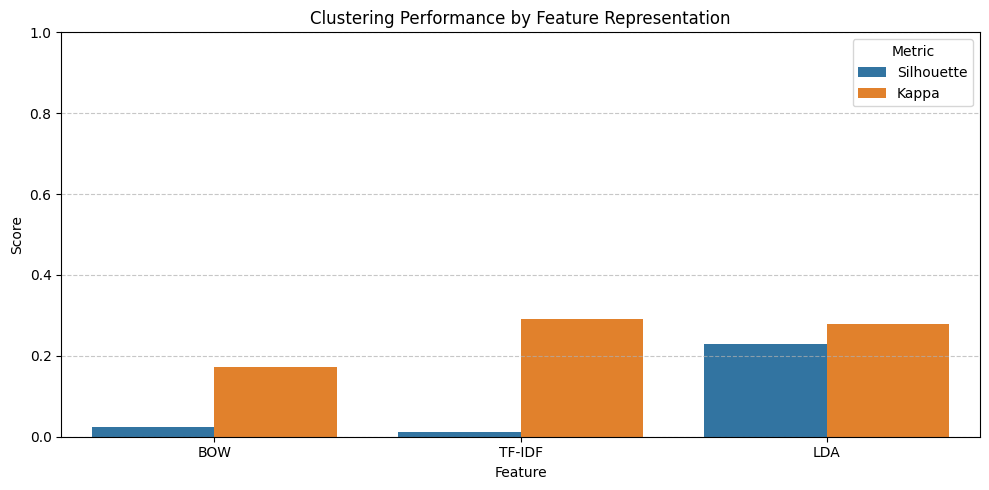

All experiments completed. Files saved in outputs/


In [ ]:
plt.figure(figsize=(10, 5))

# Plot 1: Metrics Comparison
metrics_df = kmeans_feature_compare.melt(id_vars="Feature", value_vars=["Silhouette", "Kappa"])
sns.barplot(data=metrics_df, x="Feature", y="value", hue="variable")
plt.title("Clustering Performance by Feature Representation")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(title="Metric")
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()